Подбор шага для явного метода RK4 (Робертсон):
h = 1e-04: Успешно, последние значения: [0.4730309  0.02880088 0.49816822]
h = 1e-03: Успешно, последние значения: [0.4730309  0.02880088 0.49816822]
h = 1e-02: Успешно, последние значения: [0.4730309  0.02880088 0.49816822]

Решение неявными методами (Робертсон):


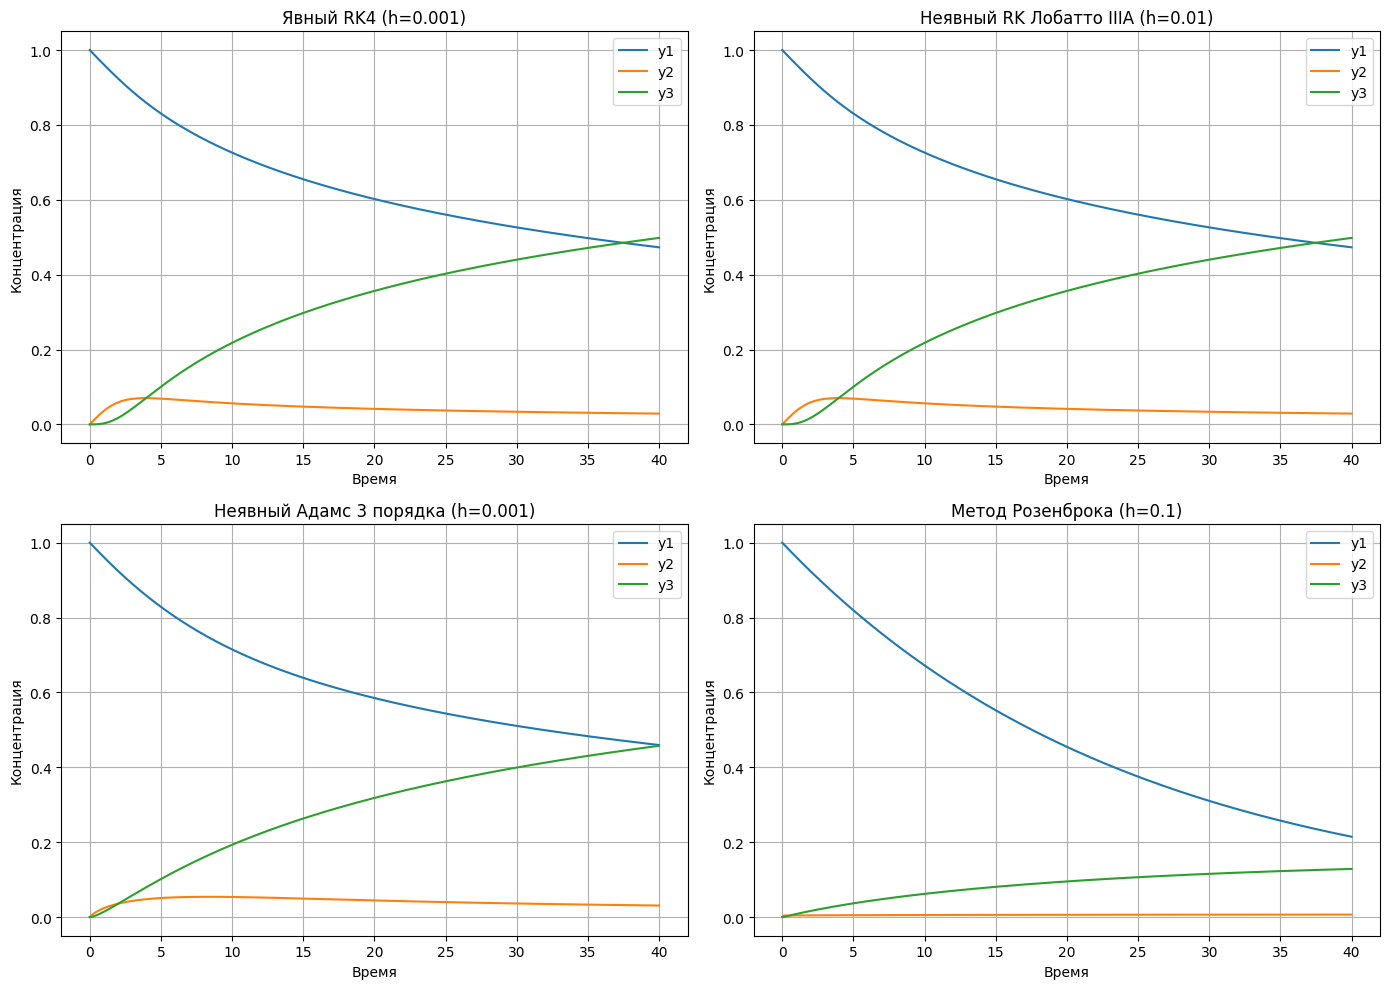

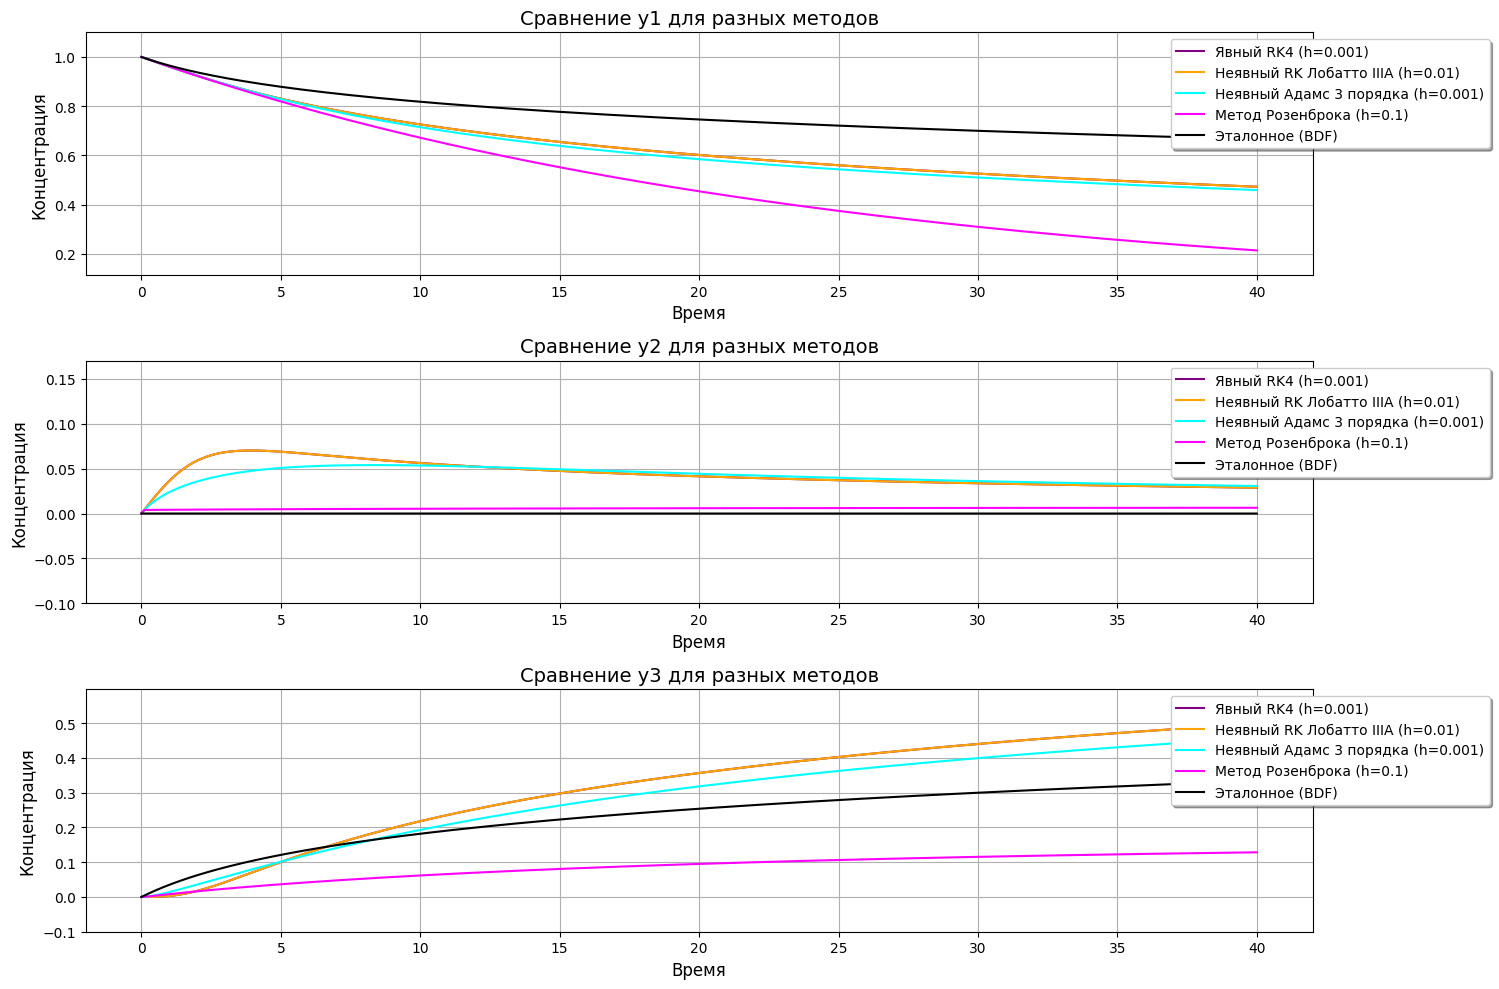


Оценка ошибок по сравнению с эталонным решением:
Максимальная ошибка RK4: 0.19306423530713934
Максимальная ошибка Неявный RK: 0.19306422733782308
Максимальная ошибка Адамс: 0.20661665008090208
Максимальная ошибка Розенброк: 0.4516294662943664

Тестирование на нежесткой системе:
RK4 (h=0.1): Успешно
Адамс (h=0.1): Успешно
Розенброк (h=0.1): Успешно

Ляпуновские показатели для системы Робертсона:
Явный RK4: [373.08972098 288.26215857   0.55755938]
Неявный RK: [373.08671298 288.2646633    0.55755927]
Адамс: [371.17707524 288.73422387   0.55672233]
Розенброк: [141.09360976 101.5351803    0.58042941]

Ляпуновские показатели для нежесткой системы:
RK4 (нежесткая): [-0.10050336 -0.20202707]
Адамс (нежесткая): [-0.10050336 -0.20202707]
Розенброк (нежесткая): [-0.10050336 -0.20202707]

Анализ для больших времен (t=1000):
Розенброк (h=1.0): Успешно, последние значения: [0.00303179 0.03642561 0.00332947]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import qr
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# Нормализованная система Робертсона
def robertson_system_normalized(t, y):
    y1, y2, y3 = y
    k1 = 0.04
    k2 = 1e4 / 1e4  # Нормализуем: делим на 1e4
    k3 = 6e7 / 1e7  # Нормализуем: делим на 1e7
    y2_scaled = y2 * 1e4
    y3_scaled = y3 * 1e4
    dy1dt = -k1 * y1 + k2 * y2_scaled * y3_scaled
    dy2dt = (k1 * y1 - k2 * y2_scaled * y3_scaled - k3 * y2_scaled**2) / 1e4
    dy3dt = (k3 * y2_scaled**2) / 1e4
    return np.array([dy1dt, dy2dt, dy3dt])

# Якобиан нормализованной системы
def robertson_jac_normalized(t, y):
    y1, y2, y3 = y
    k1 = 0.04
    k2 = 1.0  # После нормализации
    k3 = 6.0  # После нормализации
    y2_scaled = y2 * 1e4
    y3_scaled = y3 * 1e4
    J = np.array([
        [-k1, k2 * 1e4 * y3_scaled, k2 * 1e4 * y2_scaled],
        [k1 / 1e4, -k2 * 1e4 * y3_scaled - 2 * k3 * 1e4 * y2_scaled, -k2 * 1e4 * y2_scaled],
        [0.0, 2 * k3 * 1e4 * y2_scaled, 0.0]
    ])
    epsilon = 1e-3
    return J + epsilon * np.eye(3)

# Функция для денормализации результатов
def denormalize_solution(y):
    y[:, 1] *= 1e4
    y[:, 2] *= 1e4
    return y

# Нежесткая система для теста
def non_stiff_system(t, y):
    A = np.array([[-0.1, 0.0], [0.0, -0.2]])
    return A @ y

# Якобиан нежесткой системы
def non_stiff_jac(t, y):
    return np.array([[-0.1, 0.0], [0.0, -0.2]])

# Начальные условия и интервал
y0 = np.array([1.0, 0.0, 0.0])
t_span = (0, 40)
y0_non_stiff = np.array([1.0, 1.0])

# 0. Явный метод Рунге-Кутта 4 порядка
def explicit_rk4(f, t_span, y0, h, num_points=1000):
    t_full = np.arange(t_span[0], t_span[1] + h, h)
    y_full = np.zeros((len(t_full), len(y0)))
    y_full[0] = y0
    for i in range(len(t_full)-1):
        k1 = f(t_full[i], y_full[i])
        k2 = f(t_full[i] + h/2, y_full[i] + h/2*k1)
        k3 = f(t_full[i] + h/2, y_full[i] + h/2*k2)
        k4 = f(t_full[i] + h, y_full[i] + h*k3)
        y_full[i+1] = y_full[i] + h/6*(k1 + 2*k2 + 2*k3 + k4)
        if np.any(np.isnan(y_full[i+1])) or np.any(np.isinf(y_full[i+1])):
            raise ValueError(f"Numerical instability detected in RK4 at step {i}")
    indices = np.linspace(0, len(t_full)-1, num_points, dtype=int)
    t = t_full[indices]
    y = y_full[indices]
    return t, y

# 1. Неявный метод Рунге-Кутта (Лобатто IIIA)
def implicit_rk_lobatto_iiia(f, t_span, y0, h, num_points=1000):
    t_full = np.arange(t_span[0], t_span[1] + h, h)
    y_full = np.zeros((len(t_full), len(y0)))
    y_full[0] = y0
    
    for i in range(len(t_full)-1):
        def equations(k_flat):
            k1 = k_flat[:3]
            k2 = k_flat[3:]
            y_intermediate = y_full[i] + h*(0.5*k1 - 0.5*k2)
            y_next = y_full[i] + h*(0.5*k1 + 0.5*k2)
            residual1 = k1 - f(t_full[i], y_intermediate)
            residual2 = k2 - f(t_full[i] + h, y_next)
            return np.concatenate([residual1, residual2])
        
        k_initial_guess = np.concatenate([f(t_full[i], y_full[i]), f(t_full[i], y_full[i])])
        
        k_sol_flat, info, ier, msg = fsolve(equations, k_initial_guess, xtol=1e-6, full_output=True)
        if ier != 1:
            raise ValueError(f"fsolve failed to converge at step {i}: {msg}")
        
        k1 = k_sol_flat[:3]
        k2 = k_sol_flat[3:]
        y_full[i+1] = y_full[i] + h*(0.5*k1 + 0.5*k2)
        
        if np.any(np.isnan(y_full[i+1])) or np.any(np.isinf(y_full[i+1])):
            raise ValueError(f"Numerical instability in Implicit RK at step {i}")
    
    indices = np.linspace(0, len(t_full)-1, num_points, dtype=int)
    t = t_full[indices]
    y = y_full[indices]
    return t, y

# 2. Неявный метод Адамса-Моултона 3 порядка
def implicit_adams(f, jac, t_span, y0, h_init, order=3, num_points=1000):
    t_full = np.arange(t_span[0], t_span[1] + h_init, h_init)
    y_full = np.zeros((len(t_full), len(y0)))
    y_full[0] = y0

    for i in range(1, order):
        k1 = f(t_full[i-1], y_full[i-1])
        k2 = f(t_full[i-1] + h_init/2, y_full[i-1] + h_init/2 * k1)
        k3 = f(t_full[i-1] + h_init/2, y_full[i-1] + h_init/2 * k2)
        k4 = f(t_full[i-1] + h_init, y_full[i-1] + h_init * k3)
        y_full[i] = y_full[i-1] + h_init/6 * (k1 + 2*k2 + 2*k3 + k4)
        if np.any(np.isnan(y_full[i])) or np.any(np.isinf(y_full[i])):
            raise ValueError(f"Numerical instability in RK4 warmup at step {i}")

    beta = [3/8, 19/24, -5/24, 1/24]

    for i in range(order-1, len(t_full)-1):
        h = h_init
        max_attempts = 5
        attempt = 0
        success = False

        while attempt < max_attempts and not success:
            try:
                y_next = y_full[i].copy()

                def equation(y_next):
                    return y_next - y_full[i] - h * (
                        beta[0]*f(t_full[i+1], y_next) +
                        beta[1]*f(t_full[i], y_full[i]) +
                        beta[2]*f(t_full[i-1], y_full[i-1]) +
                        beta[3]*f(t_full[i-2], y_full[i-2])
                    )

                tol = 1e-8
                max_iter = 100
                for j in range(max_iter):
                    F = equation(y_next)
                    if np.linalg.norm(F) < tol:
                        break
                    J = np.eye(len(y0)) - h * beta[0] * jac(t_full[i+1], y_next)
                    delta_y = np.linalg.solve(J, -F)
                    y_next += delta_y
                    if j == max_iter-1:
                        raise ValueError(f"Newton method failed to converge at step {i}, attempt {attempt}")

                if np.any(np.isnan(y_next)) or np.any(np.isinf(y_next)):
                    raise ValueError(f"NaN/Inf detected at step {i}")

                y_next = np.clip(y_next, -1e3, 1e3)
                y_full[i+1] = y_next
                success = True

            except Exception as e:
                print(f"Step {i}, Attempt {attempt} failed: {str(e)}")
                attempt += 1
                h *= 0.5

        if not success:
            raise ValueError(f"Failed to converge at step {i} after {max_attempts} attempts")

    indices = np.linspace(0, len(t_full)-1, num_points, dtype=int)
    t = t_full[indices]
    y = y_full[indices]
    return t, y

# 3. Метод Розенброка
def rosenbrock_method(f, jac, t_span, y0, h, num_points=1000):
    t_full = np.arange(t_span[0], t_span[1] + h, h)
    y_full = np.zeros((len(t_full), len(y0)))
    y_full[0] = y0
    gamma = 0.5 + np.sqrt(3)/6

    for i in range(len(t_full)-1):
        J = jac(t_full[i], y_full[i])
        I = np.eye(len(y0))
        F = f(t_full[i], y_full[i])
        k1 = np.linalg.solve(I - h*gamma*J, F)
        y_full[i+1] = y_full[i] + h * k1
        if np.any(np.isnan(y_full[i+1])) or np.any(np.isinf(y_full[i+1])):
            raise ValueError(f"Numerical instability in Rosenbrock at step {i}")
    
    indices = np.linspace(0, len(t_full)-1, num_points, dtype=int)
    t = t_full[indices]
    y = y_full[indices]
    return t, y

# Подбор шага для явного RK4
print("Подбор шага для явного метода RK4 (Робертсон):")
h_values = [1e-4, 1e-3, 1e-2]
rk4_results = []
for h in h_values:
    try:
        t_rk4, y_rk4 = explicit_rk4(robertson_system_normalized, t_span, y0, h)
        y_rk4 = denormalize_solution(y_rk4)
        rk4_results.append((t_rk4, y_rk4))
        print(f"h = {h:.0e}: Успешно, последние значения: {y_rk4[-1]}")
    except Exception as e:
        print(f"h = {h:.0e}: Ошибка - {str(e)}")

# Решение неявными методами
print("\nРешение неявными методами (Робертсон):")

# Явный RK4
h_explicit = 1e-3
t_rk4, y_rk4 = explicit_rk4(robertson_system_normalized, t_span, y0, h_explicit)
y_rk4 = denormalize_solution(y_rk4)

# Неявный RK Лобатто IIIA
h_implicit_rk = 1e-2
t_irk, y_irk = implicit_rk_lobatto_iiia(robertson_system_normalized, t_span, y0, h_implicit_rk)
y_irk = denormalize_solution(y_irk)

# Неявный Адамс
h_adams = 1e-3
t_adams, y_adams = implicit_adams(robertson_system_normalized, robertson_jac_normalized, t_span, y0, h_adams)
y_adams = denormalize_solution(y_adams)

# Розенброк
h_rosenbrock = 1e-1
t_ros, y_ros = rosenbrock_method(robertson_system_normalized, robertson_jac_normalized, t_span, y0, h_rosenbrock)
y_ros = denormalize_solution(y_ros)

# Эталонное решение (для ненормализованной системы)
def robertson_system(t, y):
    y1, y2, y3 = y
    dy1dt = -0.04 * y1 + 1e4 * y2 * y3
    dy2dt = 0.04 * y1 - 1e4 * y2 * y3 - 6e7 * y2**2
    dy3dt = 6e7 * y2**2
    return np.array([dy1dt, dy2dt, dy3dt])

sol = solve_ivp(robertson_system, t_span, y0, method='BDF', rtol=1e-8, atol=1e-10)

# Визуализация
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
plt.plot(t_rk4, y_rk4[:, 0], label='y1')
plt.plot(t_rk4, y_rk4[:, 1], label='y2')
plt.plot(t_rk4, y_rk4[:, 2], label='y3')
plt.title(f'Явный RK4 (h={h_explicit})')
plt.xlabel('Время')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t_irk, y_irk[:, 0], label='y1')
plt.plot(t_irk, y_irk[:, 1], label='y2')
plt.plot(t_irk, y_irk[:, 2], label='y3')
plt.title(f'Неявный RK Лобатто IIIA (h={h_implicit_rk})')
plt.xlabel('Время')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t_adams, y_adams[:, 0], label='y1')
plt.plot(t_adams, y_adams[:, 1], label='y2')
plt.plot(t_adams, y_adams[:, 2], label='y3')
plt.title(f'Неявный Адамс 3 порядка (h={h_adams})')
plt.xlabel('Время')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(t_ros, y_ros[:, 0], label='y1')
plt.plot(t_ros, y_ros[:, 1], label='y2')
plt.plot(t_ros, y_ros[:, 2], label='y3')
plt.title(f'Метод Розенброка (h={h_rosenbrock})')
plt.xlabel('Время')
plt.ylabel('Концентрация')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Сравнительные графики с синхронизацией времени
t_common = np.sort(np.concatenate([t_rk4, t_irk, t_adams, t_ros, sol.t]))
sol_interp_y1 = interp1d(sol.t, sol.y[0], kind='linear', fill_value='extrapolate')(t_common)
sol_interp_y2 = interp1d(sol.t, sol.y[1], kind='linear', fill_value='extrapolate')(t_common)
sol_interp_y3 = interp1d(sol.t, sol.y[2], kind='linear', fill_value='extrapolate')(t_common)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(t_common, np.interp(t_common, t_rk4, y_rk4[:, 0]), '-', color='purple', label=f'Явный RK4 (h={h_explicit})')
plt.plot(t_common, np.interp(t_common, t_irk, y_irk[:, 0]), '-', color='orange', label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk})')
plt.plot(t_common, np.interp(t_common, t_adams, y_adams[:, 0]), '-', color='cyan', label=f'Неявный Адамс 3 порядка (h={h_adams})')
plt.plot(t_common, np.interp(t_common, t_ros, y_ros[:, 0]), '-', color='magenta', label=f'Метод Розенброка (h={h_rosenbrock})')
plt.plot(t_common, sol_interp_y1, '-', color='black', label='Эталонное (BDF)')
plt.title('Сравнение y1 для разных методов', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Концентрация', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fancybox=True, shadow=True, fontsize=10)
plt.grid()
plt.ylim(min(sol_interp_y1.min(), y_rk4[:, 0].min(), y_irk[:, 0].min(), y_adams[:, 0].min(), y_ros[:, 0].min()) - 0.1,
         max(sol_interp_y1.max(), y_rk4[:, 0].max(), y_irk[:, 0].max(), y_adams[:, 0].max(), y_ros[:, 0].max()) + 0.1)

plt.subplot(3, 1, 2)
plt.plot(t_common, np.interp(t_common, t_rk4, y_rk4[:, 1]), '-', color='purple', label=f'Явный RK4 (h={h_explicit})')
plt.plot(t_common, np.interp(t_common, t_irk, y_irk[:, 1]), '-', color='orange', label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk})')
plt.plot(t_common, np.interp(t_common, t_adams, y_adams[:, 1]), '-', color='cyan', label=f'Неявный Адамс 3 порядка (h={h_adams})')
plt.plot(t_common, np.interp(t_common, t_ros, y_ros[:, 1]), '-', color='magenta', label=f'Метод Розенброка (h={h_rosenbrock})')
plt.plot(t_common, sol_interp_y2, '-', color='black', label='Эталонное (BDF)')
plt.title('Сравнение y2 для разных методов', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Концентрация', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fancybox=True, shadow=True, fontsize=10)
plt.grid()
plt.ylim(min(sol_interp_y2.min(), y_rk4[:, 1].min(), y_irk[:, 1].min(), y_adams[:, 1].min(), y_ros[:, 1].min()) - 0.1,
         max(sol_interp_y2.max(), y_rk4[:, 1].max(), y_irk[:, 1].max(), y_adams[:, 1].max(), y_ros[:, 1].max()) + 0.1)

plt.subplot(3, 1, 3)
plt.plot(t_common, np.interp(t_common, t_rk4, y_rk4[:, 2]), '-', color='purple', label=f'Явный RK4 (h={h_explicit})')
plt.plot(t_common, np.interp(t_common, t_irk, y_irk[:, 2]), '-', color='orange', label=f'Неявный RK Лобатто IIIA (h={h_implicit_rk})')
plt.plot(t_common, np.interp(t_common, t_adams, y_adams[:, 2]), '-', color='cyan', label=f'Неявный Адамс 3 порядка (h={h_adams})')
plt.plot(t_common, np.interp(t_common, t_ros, y_ros[:, 2]), '-', color='magenta', label=f'Метод Розенброка (h={h_rosenbrock})')
plt.plot(t_common, sol_interp_y3, '-', color='black', label='Эталонное (BDF)')
plt.title('Сравнение y3 для разных методов', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Концентрация', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fancybox=True, shadow=True, fontsize=10)
plt.grid()
plt.ylim(min(sol_interp_y3.min(), y_rk4[:, 2].min(), y_irk[:, 2].min(), y_adams[:, 2].min(), y_ros[:, 2].min()) - 0.1,
         max(sol_interp_y3.max(), y_rk4[:, 2].max(), y_irk[:, 2].max(), y_adams[:, 2].max(), y_ros[:, 2].max()) + 0.1)

plt.tight_layout()
plt.show()

# Оценка ошибок
print("\nОценка ошибок по сравнению с эталонным решением:")
sol_interp = interp1d(sol.t, sol.y.T, axis=0, fill_value="extrapolate")
error_rk4 = np.max(np.abs(y_rk4 - sol_interp(t_rk4)))
print(f"Максимальная ошибка RK4: {error_rk4}")
error_irk = np.max(np.abs(y_irk - sol_interp(t_irk)))
print(f"Максимальная ошибка Неявный RK: {error_irk}")
error_adams = np.max(np.abs(y_adams - sol_interp(t_adams)))
print(f"Максимальная ошибка Адамс: {error_adams}")
error_ros = np.max(np.abs(y_ros - sol_interp(t_ros)))
print(f"Максимальная ошибка Розенброк: {error_ros}")

# Тестирование на нежесткой системе
print("\nТестирование на нежесткой системе:")
for h in [0.1]:
    try:
        t_rk4_ns, y_rk4_ns = explicit_rk4(non_stiff_system, t_span, y0_non_stiff, h)
        print(f"RK4 (h={h}): Успешно")
        t_adams_ns, y_adams_ns = implicit_adams(non_stiff_system, non_stiff_jac, t_span, y0_non_stiff, h)
        print(f"Адамс (h={h}): Успешно")
        t_ros_ns, y_ros_ns = rosenbrock_method(non_stiff_system, non_stiff_jac, t_span, y0_non_stiff, h)
        print(f"Розенброк (h={h}): Успешно")
    except Exception as e:
        print(f"Ошибка на нежесткой системе (h={h}): {str(e)}")

# Расчет Ляпуновских показателей
def lyapunov_exponents(y, t, jac_func):
    n = y.shape[1]  # Динамически определяем количество переменных
    N = len(y)
    Q = np.eye(n)
    exponents = np.zeros(n)
    
    for i in range(N-1):
        J = jac_func(t[i], y[i])
        A = np.eye(n) + (t[i+1]-t[i])*J
        Q, R = qr(A @ Q)
        diag_R = np.abs(np.diag(R))
        diag_R = np.maximum(diag_R, 1e-16)
        exponents += np.log(diag_R)
        if np.any(np.isnan(exponents)) or np.any(np.isinf(exponents)):
            raise ValueError(f"NaN/Inf in Lyapunov exponents at step {i}")
    
    return exponents / (t[-1] - t[0])

print("\nЛяпуновские показатели для системы Робертсона:")
try:
    print(f"Явный RK4: {lyapunov_exponents(y_rk4, t_rk4, robertson_jac_normalized)}")
    print(f"Неявный RK: {lyapunov_exponents(y_irk, t_irk, robertson_jac_normalized)}")
    print(f"Адамс: {lyapunov_exponents(y_adams, t_adams, robertson_jac_normalized)}")
    print(f"Розенброк: {lyapunov_exponents(y_ros, t_ros, robertson_jac_normalized)}")
except Exception as e:
    print(f"Ошибка при расчете Ляпуновских показателей: {str(e)}")

# Ляпуновские показатели для нежесткой системы
print("\nЛяпуновские показатели для нежесткой системы:")
try:
    print(f"RK4 (нежесткая): {lyapunov_exponents(y_rk4_ns, t_rk4_ns, non_stiff_jac)}")
    print(f"Адамс (нежесткая): {lyapunov_exponents(y_adams_ns, t_adams_ns, non_stiff_jac)}")
    print(f"Розенброк (нежесткая): {lyapunov_exponents(y_ros_ns, t_ros_ns, non_stiff_jac)}")
except Exception as e:
    print(f"Ошибка при расчете Ляпуновских показателей для нежесткой системы: {str(e)}")

# Анализ для больших времен
print("\nАнализ для больших времен (t=1000):")
t_span_large = (0, 1000)
h_large = 1.0
try:
    t_ros_large, y_ros_large = rosenbrock_method(robertson_system_normalized, robertson_jac_normalized, t_span_large, y0, h_large)
    y_ros_large = denormalize_solution(y_ros_large)
    print(f"Розенброк (h={h_large}): Успешно, последние значения: {y_ros_large[-1]}")
except Exception as e:
    print(f"Ошибка для больших времен: {str(e)}")